# Imports

In [1]:
import os
import pickle
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# Load Data

In [3]:
# Folder containing the datset
data_dir = '../dataset/processed_topic_data'

In [4]:
def load_data(filename, data_dir, data_type):
    h5f = h5py.File(os.path.join(data_dir, filename), 'r')
    data = h5f[data_type][:]
    h5f.close()
    return data

Load training data

In [5]:
train_images = load_data('train_images.h5', data_dir, 'images')

In [6]:
train_categories = load_data('train_categories.h5', data_dir, 'labels')

Load validation data

In [7]:
val_images = load_data('val_images.h5', data_dir, 'images')

In [8]:
val_categories = load_data('val_categories.h5', data_dir, 'labels')

Load test data

In [9]:
test_images = load_data('test_images.h5', data_dir, 'images')

In [10]:
test_categories = load_data('test_categories.h5', data_dir, 'labels')

Load mapping

In [11]:
with open('../dataset/coco_raw.pickle', 'rb') as file:
    coco_raw = pickle.load(file)
id_category = coco_raw['id_category']

In [12]:
num_classes = len(id_category)
num_classes

80

In [13]:
num_images_train = train_images.shape[0]
num_images_train

19324

### Display a sample image

person
skis


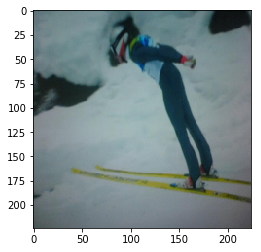

In [14]:
# display image
idx = 10

for category, value in enumerate(train_categories[idx]):
    if value != 0:
        print(id_category[category])

plt.imshow(train_images[idx])
plt.show()

# Define Model

In [15]:
# Download VGG19 model along with the fully-connected layers
model = VGG19(include_top=True, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
# Extract the second last fully connected layer
conv_layer = model.get_layer('fc2')

In [17]:
conv_layer.output

<tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>

In [18]:
# Create model
conv_model = Model(inputs=model.input, outputs=conv_layer.output)

In [19]:
# Start a new Keras Sequential model
image_model = Sequential()

# Add the VGG19 model
image_model.add(conv_model)

# Add the final layer for the actual classification
image_model.add(Dense(num_classes, activation='sigmoid'))

In [20]:
# Set the VGG19 layers to be non-trainable
conv_model.trainable = False
for layer in conv_model.layers:
    layer.trainable = False

In [21]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 4096)              139570240 
_________________________________________________________________
dense (Dense)                (None, 80)                327760    
Total params: 139,898,000
Trainable params: 327,760
Non-trainable params: 139,570,240
_________________________________________________________________


Visualize model

In [ ]:
plot_model(image_model, to_file='image_model.png', show_shapes=True, show_layer_names=True)

In [22]:
# Compile the model
optimizer = Adam(lr=1e-3)

image_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [23]:
weights_dir = 'weights'
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

path_checkpoint = os.path.join(weights_dir, 'checkpoint.keras')

# set model callbacks
tb = TensorBoard(log_dir=os.path.join(weights_dir, 'tensorboard-logs'), histogram_freq=0, write_graph=False)
checkpoint = ModelCheckpoint(filepath=path_checkpoint, verbose=1, save_weights_only=True)
# early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

callbacks = [tb, checkpoint]

# Train Model

In [24]:
# Load previously trained model weights
try:
    image_model.load_weights(path_checkpoint)
    print('Checkpoint loaded.')
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Checkpoint loaded.


In [25]:
batch_size = 64
epochs = 100

In [ ]:
image_model.fit(
    x=train_images,
    y=train_categories,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(val_images, val_categories)
)

# Test Model

In [26]:
def get_predictions(image, label, id_category):
    image_batch = np.expand_dims(image, axis=0)
    predictions = image_model.predict(image_batch)
    
    prediction_labels = []
    for index, prediction_probability in enumerate(predictions[0]):
        if prediction_probability > 0.5:
            prediction_labels.append(id_category[index])
    
    true_labels = []
    for index, value in enumerate(label):
        if value == 1:
            true_labels.append(id_category[index])
    
    print('True labels:', true_labels)
    print('Predictions:', prediction_labels)
    
    print('Image:')
    plt.imshow(image)
    plt.show()

In [27]:
idx = 789

True labels: ['person', 'surfboard']
Predictions: ['person', 'surfboard']
Image:


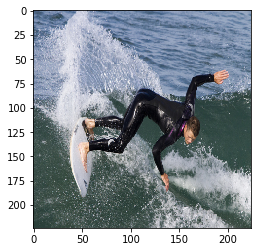

In [28]:
get_predictions(test_images[idx], test_categories[idx], id_category)

In [ ]:
get_predictions(val_images[idx], val_categories[idx], id_category)

In [ ]:
get_predictions(train_images[idx], train_categories[idx], id_category)